In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
nltk.download('stopwords')
import nltk
import re
import tensorflow
import torch
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohsenboughriou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#we concatenate two data sets in order to obtain two balanced classes in our dataset 
df=pd.read_csv(r'....labeled_data.csv')
df1=pd.read_csv(r'..../TwitterHate.csv')

In [3]:
col=[0,1,2,3,4]
df=df.drop(df.columns[col], axis=1)

In [4]:
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [5]:
df['class'] = df['class'].replace([0],1)
df['class'] = df['class'].replace([2],0)
df['class'].value_counts()

1    20620
0     4163
Name: class, dtype: int64

In [6]:
df1=df1.drop('id',axis=1)
df1=df1.rename(columns={'label':'class'})

In [7]:
df1['class'].value_counts()

0    29720
1     2242
Name: class, dtype: int64

In [8]:
df2=df1.loc[df1['class'] == 0]
df1=df2.iloc[0:16457]
df=pd.concat([df,df1], axis=0)

In [9]:
df['class'].value_counts()

0    20620
1    20620
Name: class, dtype: int64

In [10]:
tweet=df.tweet

In [11]:
tweet=(tweet)
tweet.reset_index(drop=True, inplace=True)

In [12]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

def preprocess(tweet):  
    
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat,' ')

    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    tweet_lower = newtweet.str.lower()
    
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

df['processed_tweets'] = processed_tweets
print(df[["tweet","processed_tweets"]].head(10))

/var/folders/xb/qwgsqylj7j7c10t_q8rvnf_c0000gn/T/ipykernel_1162/2767197856.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
/var/folders/xb/qwgsqylj7j7c10t_q8rvnf_c0000gn/T/ipykernel_1162/2767197856.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=punc_remove.str.replace(r'\s+', ' ')
/var/folders/xb/qwgsqylj7j7c10t_q8rvnf_c0000gn/T/ipykernel_1162/2767197856.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
/var/folders/xb/qwgsqylj7j7c10t_q8rvnf_c0000gn/T/ipykernel_1162/2767197856.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')


                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
6  !!!!!!"@__BrighterDays: I can not just sit up ...   
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
8  " &amp; you might not get ya bitch back &amp; ...   
9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                    processed_tweets  
0  woman complain cleaning house amp man always t...  
1  boy dats cold tyga dwn bad cuffin dat hoe st p...  
2       dawg ever fuck bitch start cry confused shit  
3                                   look like tranny  
4     shit hear might true might faker bitch told ya  
5  shit blows claim faithful somebody still fucki... 

In [13]:
np.shape(processed_tweets)

(41240,)

In [14]:
# we define the vocabulary size
voc_size=4000

onehot_tweets = [one_hot(words, voc_size) for words in processed_tweets]


In [15]:
max_len=23
embedded_tweets=pad_sequences(onehot_tweets,padding='pre',maxlen=max_len)
print(embedded_tweets)

[[   0    0    0 ...  387 1518 1839]
 [   0    0    0 ... 1538 3680 1538]
 [   0    0    0 ...  563  441 2803]
 ...
 [   0    0    0 ...  206 3295 1645]
 [   0    0    0 ... 1834 2696 3637]
 [   0    0    0 ...  329 1133 1081]]


In [16]:
y=df['class']

In [17]:
X_train,X_val,y_train,y_val=train_test_split(embedded_tweets,y, train_size=0.7,test_size=0.3, random_state=42)

In [18]:
X_train=list(X_train)
y_train=list(y_train)
X_val=list(X_val)
y_val=list(y_val)
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

28867
28867
12372
12372


In [19]:
#we define our model
embedding_vector_features=50
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(LSTM(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
print(model.summary())

Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 50)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 260,501
Trainable params: 260,501
Non-trainable params: 0
_________________________________________________________________
None


2023-04-03 12:18:13.646752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-03 12:18:13.647131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=5,batch_size=512)


Epoch 1/5


2023-04-03 12:18:13.890022: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-03 12:18:14.317259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8464

2023-04-03 12:18:44.538729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 32s 541ms/step - loss: 0.3959 - accuracy: 0.8464 - val_loss: 0.1856 - val_accuracy: 0.9381
Epoch 2/5
57/57 [==============================] - 30s 534ms/step - loss: 0.1332 - accuracy: 0.9541 - val_loss: 0.1640 - val_accuracy: 0.9439
Epoch 3/5
57/57 [==============================] - 30s 532ms/step - loss: 0.0983 - accuracy: 0.9644 - val_loss: 0.1735 - val_accuracy: 0.9415
Epoch 4/5
57/57 [==============================] - 30s 531ms/step - loss: 0.0755 - accuracy: 0.9726 - val_loss: 0.2006 - val_accuracy: 0.9406
Epoch 5/5
57/57 [==============================] - 30s 531ms/step - loss: 0.0583 - accuracy: 0.9782 - val_loss: 0.2485 - val_accuracy: 0.9355


In [21]:
#We save the model
model.save(r'..../lstm model')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


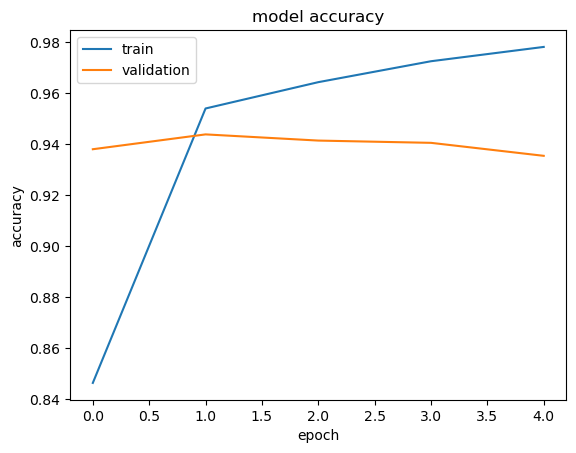

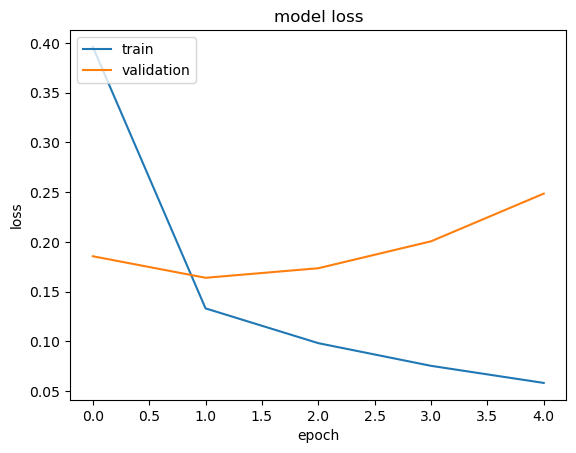

In [22]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
y_val_pred=model.predict(X_val)

  3/387 [..............................] - ETA: 13s

2023-04-03 12:20:47.015595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


387/387 [==============================] - 11s 28ms/step


In [28]:
y_val_pred = list(map(lambda x: 0 if x<0.5 else 1, y_val_pred))


In [25]:
confusion_matrix(y_val,y_val_pred)

array([[5766,  470],
       [ 328, 5808]])

In [26]:
target_names = ['No hate speech','Hate speech']
print(classification_report(y_val, y_val_pred, target_names=target_names))

                precision    recall  f1-score   support

No hate speech       0.95      0.92      0.94      6236
   Hate speech       0.93      0.95      0.94      6136

      accuracy                           0.94     12372
     macro avg       0.94      0.94      0.94     12372
  weighted avg       0.94      0.94      0.94     12372

